# ASTR302 Lab 5: Fitting a Line and Related Adventures

In this Lab you will learn about model fitting (a basic line) and some of the things to keep in mind when doing so.

## Testing a Model

The basic idea behind model testing is to compare the model to the data utilizing the uncertainties. For example the model may predict a value of 10, the data may say 12. Is this in agreement or not? Well, it depends on the measurement uncertainty -- if the measurement is $12\pm 3$, then the model is discrepant **less than at the 1$\sigma$ level** and so consistent with the model. On other hand if the measurement is $12 \pm 0.1$, then the model is 20$\sigma$ discrepant and therefore highly discrepant. Scientific inference is all in the uncertainties!

To quantify this comparison we sum the differences between model and data for as many measurements as are available and that sum is called $\chi^2$:

$$\chi^2 = \sum_i^N \frac{(data_i - model_i)^2}{\sigma^2}$$

Rule of thumb is that if $\chi^2 \sim N$ then you cannot reject the model (because that would mean that typically each point is about 1$\sigma$ away from the model). 
Remember that you can only exclude models, never confirm. It is also very dangerous to say that one model is better than another by directly comparing $\chi^2$ values. There are ways of doing this type of comparison, but simply comparing $\chi^2$ values is not one of those ways.




## $\chi^2$ Minimization

Within a set of models, our example will be a linear relation between two measurements, the parameters of that relation can be recovered by finding which line minimizes $\chi^2$. The simplicity of this model allows for an analytic solution, but in the interest of generality we will explore a numerical solution below.

Before we start, lets import the packages you will be needing for this Lab.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

Now, lets get started on working with some data. I've set up a set of x and y values. First, we'll plot them and then lets fit a least squares regression line. As always, there are various ways to do this, but I use a function from scipy called linregress.

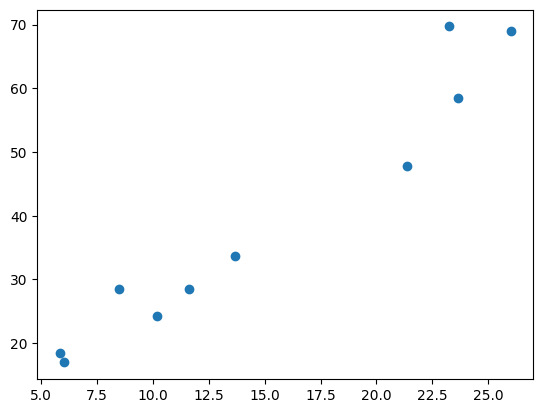

The best fit line has slope = 2.515 and intercept = 1.765


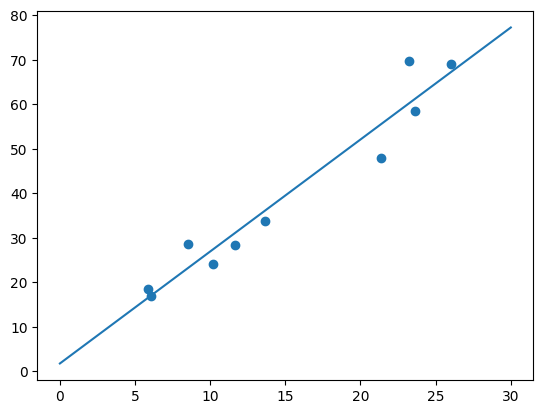

In [2]:
# here are some values to fit
x = np.array([13.66590137, 10.17672147, 11.63717252, 26.00047505, 23.24155687, 6.03897333, 23.63114056, 5.85846547, 21.36203145, 8.49415545])
y = np.array([33.66068149, 24.17267066, 28.44237968, 68.96767387, 69.71136072, 16.95320644, 58.47925607, 18.48669015, 47.83245772, 28.51103313])

# now a simple scatter plot
plt.scatter(x,y)
plt.show()

result = stats.linregress(x,y)
print(f'The best fit line has slope = {result.slope:.3f} and intercept = {result.intercept:.3f}')

# now lets plot that best fit line and the data
plt.scatter(x,y)
plt.plot((0,30),(result.intercept,result.slope*30+result.intercept))
plt.show()

If you look up the documentation on stats.lingress (never a bad idea when using built-in functions) you'll learn that it returns a few other values in addition to the slope and intercept of the line. The r_value and p_value we will get to later, but now lets consider stderr and intercept_stderr, which are the uncertainties on the slope and intercept.

In [3]:
print(f'The best fit line has slope = {result.slope:.3f} +- {result.stderr:.3f} and intercept = {result.intercept:.3f} +- {result.intercept_stderr:.3f}')

The best fit line has slope = 2.515 +- 0.222 and intercept = 1.765 +- 3.714


If you are starting to activate your statistics spidey-sense, you should feel a bit quesy about now. What happened to the uncertainties in the data? Surely if the data had larger rather than smaller uncertainties the unceratinties on the fitted parameters should also be larger rather than smaller (and don't call me Shirley - for those of you who have not seen the Airplane or Police Squad movies/tv show, do so - and surely thank me later). 

Well, the linregress algorithm assumes that the uncertainties are such that they produce $\chi^2 = 1$. This is not only a problem for the determination on the uncertainties in the slope and intercept, but could give you a completely wrong answer if some of the data have much larger or smaller uncertainties than the rest. Lets see how we can fix this and get some intuition on the damage we could have done. To do this we will need a function fitter that offers a bit more flexibility. We will use scipy.curfit. As the name implies, this can fit an arbitrary curve, but we can certainly use it to fit a line.

Unweighted fit parameters:
The best fit line has slope = 2.515 +- 0.222 and intercept = 1.765 +- 3.714

Equally weighted fit parameters (but with larger uncertainties):
The best fit line has slope = 2.515 +- 0.428 and intercept = 1.765 +- 7.158
Scatter about line in units of sigma = 0.464


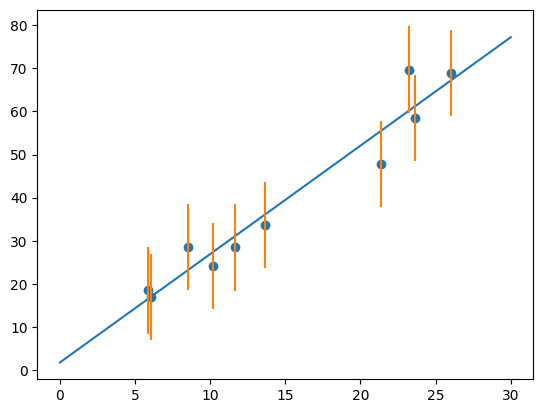

In [4]:
# defines our simple line as function f
def f(x, A, B):
    return A*x + B

def rms(y, yfit, sigma):
    return np.sqrt(np.sum((y-yfit)**2/sigma**2)/len(y))

# P0 is a starting point for the values of m & B - as long as you aren't too far off the algorithm will still find the best fit
p0 = 0, 0
popt, pcov = curve_fit(f, x, y, p0)

print('Unweighted fit parameters:')
print(f'The best fit line has slope = {popt[0]:.3f} +- {np.sqrt(pcov[0,0]):.3f} and intercept = {popt[1]:.3f} +- {np.sqrt(pcov[1,1]):.3f}')
print()

# arbitrarily setting sigma
sigma = np.ones(len(y))*10.0

# Weighted fit
popt2, pcov2 = curve_fit(f, x, y, p0, sigma=sigma, absolute_sigma=True)
yfit2 = f(x, *popt)

print('Equally weighted fit parameters (but with larger uncertainties):')
print(f'The best fit line has slope = {popt2[0]:.3f} +- {np.sqrt(pcov2[0,0]):.3f} and intercept = {popt2[1]:.3f} +- {np.sqrt(pcov2[1,1]):.3f}')
print(f'Scatter about line in units of sigma = {rms(y,yfit2,sigma):.3f}')


plt.scatter(x,y)
plt.plot((0,30),(popt[1],popt[0]*30+popt[1]))
plt.errorbar(x,y,sigma,ls='none')     # the ls='none' is needed so python doesn't connect your points
plt.show()

We see in these two instance that the recovered values of the slope and intercept do not change (they are not senstive to the choice of the uncertainties - as long as the uncertainties are all equal). We have plotted the data with the large uncertainties that we have assigned each point. After assigning these uncertainties the uncertainties on the slope and intercept do increase (and we've defined them to be larger than the $\chi^2 = 1$ condition). <div class="alert alert-info">How can you tell that is indeed so?</div>

<div class="alert alert-block alert-success">
Answer: After assigning larger uncertainties to the data points (with sigma = 10), we see that the uncertainties on the slope and intercept increase. For example, the uncertainty on the slope goes from ±0.222 (unweighted) to ±0.428 (weighted), and the uncertainty on the intercept goes from ±3.714 (unweighted) to ±7.158 (weighted). This happens because larger uncertainties in the data make the model less confident about the exact values of the slope and intercept, leading to larger uncertainties on those parameters. In summary, when we assign larger uncertainties to the data, the model becomes less precise, and the uncertainties on the slope and intercept increase accordingly.
</div>

You'll also notice that the curfit algorithm also returns something called pcov, which is the covariance matrix. In fact, we've used the diagonal elements (pcov[0,0] and p[1,1]) to determine the uncertainties in the slope and intercept). We have done this because the diagonal elements are the variances for the slope and intercept, but the off-diagonal terms are the covariances (e.g., measuring how the model fit behaves as slope and intercept are varied). Covariances are important because they can highlight ambiguities in the fit and the recovered parameters. <div class="alert alert-info">Can you describe in words or give and example of why the slope and intercept are co-variant?</div>

<div class="alert alert-block alert-success">
Answer: The slope and intercept are said to be co-variant because changes in one parameter (slope or intercept) can influence the other, especially when fitting a model to data. In a linear regression, the slope determines the steepness of the line, and the intercept determines where the line crosses the y-axis. If the slope changes, it can affect the position of the line, which in turn affects the intercept.


Example: If you increase the slope of the line, the position of the line will shift, which may cause the intercept to change as well. So, if the slope gets steeper, the intercept might also increase or decrease depending on the data. This relationship is shown in the covariance matrix, where the off-diagonal elements represent how changes in the slope affect the intercept and vice versa.
</div>

Now lets proceed to see how unequal weights can affect things.

Unequally weighted fit parameters: [ 3.12574412 -3.3451513 ]
The best fit line has slope = 3.126 +- 0.293 and intercept = -3.345 +- 6.666


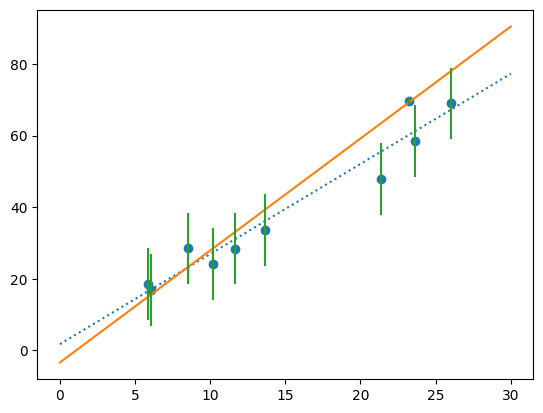

In [5]:
sigma[4] = 1
# Weighted fit with one point (#4) being much more highly weighted because its uncertainty is set to be much smaller
popt3, pcov3 = curve_fit(f, x, y, p0, sigma=sigma, absolute_sigma=True)

print('Unequally weighted fit parameters:', popt3)
print(f'The best fit line has slope = {popt3[0]:.3f} +- {np.sqrt(pcov3[0,0]):.3f} and intercept = {popt3[1]:.3f} +- {np.sqrt(pcov3[1,1]):.3f}')

plt.scatter(x,y)
plt.plot((0,30),(popt2[1],popt2[0]*30+popt2[1]),linestyle='dotted')
plt.plot((0,30),(popt3[1],popt3[0]*30+popt3[1]))
plt.errorbar(x,y,sigma,ls='none')     # the ls='none' is needed so python doesn't connect your points
plt.show()

In the plot we have shown both the previous fitted line (dotted) and the current best fit (solid). The unequal weighting of the one point has clearly affected the fit. In much the same way an erroneous point (an outlier) can distort the fit. You'll be sorely tempted to remove data at some point in your scientific career - and although a bad act in principle, it is sometimes justifiable and clearly some data are bad for both known and unknown reasons. <div class="alert alert-info">Discuss how might you identify an outlier and justify its removal from the sample?</div>

<div class="alert alert-block alert-success">
Answer: You can identify outliers by looking for unusual data points through visualization, statistical methods like z-scores, or by assessing their influence on the fit. Any removal should be justified by a reasonable explanation based on experimental context, data quality, or the relevance of the point to the study.
</div>

To finish this lab off, we're going back to Hubble's original expansion of the Universe data (Hubble 1926; https://www.pnas.org/doi/pdf/10.1073/pnas.15.3.168). I've already put in the velocities and magnitudes. From the absolute and apparent magnitudes, which you can find out more about how he got the absolute magnitudes from the paper, I've also coded in the coversion to distance in Mpc. Go ahead and derive the Hubble constant (the slope of the line). <div class="alert alert-info">Compare to modern values and discuss. Fill out the code cell below. </div>

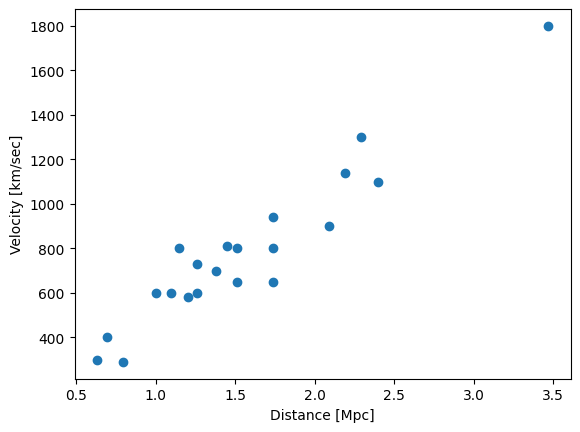

In [6]:
velocities = np.array([650,1800,1300,300,800,700,400,600,290,600,940,810,600,730,800,800,580,1100,1140,900,650])
abs_mag = np.array([-13.9,-16.8,-15.7,-13.8,-12.8,-15.0,-14.3,-16.1,-15.5,-15.5,-16.2,-16.4,-14.0,-15.4,-16.0,-16.1,-14.3,-15.9,-17.6,-15.5,-14.5])
app_mag = np.array([12.0,10.9,11.1,10.2,12.5,10.7,9.9,9.4,9.0,9.5,10.0,9.4,11.2,10.1,9.9,10.1,11.1,11.0,9.1,11.1,11.7])

dist = 10**(((app_mag - abs_mag) + 5)/5)/1e6   # to get Mpc

plt.scatter(dist,velocities)
plt.ylabel('Velocity [km/sec]')
plt.xlabel('Distance [Mpc]')

# add here your line fitting code
# and plot your best fit line

plt.show()

Discuss result:

## Conclusion: 

<div class="alert alert-info"> Save your notebook.  Append your LastNameFirstInitial to the filename and submit via D2L. </div>